In [218]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Flatten
from keras.layers import Conv1D, LSTM, Dropout, Bidirectional,LayerNormalization,SimpleRNN
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [219]:
df = pd.read_csv('./data/stock.csv', index_col=0)

In [220]:
df.columns

Index(['종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

In [221]:
df = df[df['종목명']=='삼성전자']

In [222]:
df = df[['시가','고가','저가','종가']]

In [223]:
df

,시가,고가,저가,종가
일자,,,,
20210601,80500,81300,80100,80600
20210602,80400,81400,80300,80800
20210603,81300,83000,81100,82800
20210604,82700,82700,81500,82200
20210607,82700,82800,81600,81900
...,...,...,...,...
20230523,68500,68700,68100,68400
20230524,68100,68700,68000,68500
20230525,69900,70000,68700,68800


In [224]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

df = MinMaxScaler(df)

In [225]:
dfx = df[['시가','고가','저가']]
dfy = df[['종가']]

dfx.columns = ['Open','High','Low']
dfy.columns = [['Close']]

In [226]:
dfy

,Close
일자,
20210601,0.924092
20210602,0.930693
20210603,0.996700
20210604,0.976898
20210607,0.966997
...,...
20230523,0.521452
20230524,0.524752
20230525,0.534653


In [227]:
time_step = 5
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [228]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(489, 5, 3)

In [229]:
dfy

,Close
일자,
20210601,0.924092
20210602,0.930693
20210603,0.996700
20210604,0.976898
20210607,0.966997
...,...
20230523,0.521452
20230524,0.524752
20230525,0.534653


In [230]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((342, 5, 3), (147, 5, 3), (342, 1), (147, 1))

In [231]:
model = Sequential()
model.add(LSTM(128, input_shape = (X.shape[1:]), return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Dense(1))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 5, 128)            67584     
                                                                 
 lstm_28 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 118049 (461.13 KB)
Trainable params: 118049 (461.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [233]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.3, shuffle=False)

Epoch 1/500
8/8 [==============================] - 11s 311ms/step - loss: 0.2272 - mae: 0.3781 - val_loss: 0.0491 - val_mae: 0.2153
Epoch 2/500
8/8 [==============================] - 0s 39ms/step - loss: 0.0530 - mae: 0.1805 - val_loss: 0.0086 - val_mae: 0.0820
Epoch 3/500
8/8 [==============================] - 0s 27ms/step - loss: 0.0195 - mae: 0.1107 - val_loss: 0.0065 - val_mae: 0.0690
Epoch 4/500
8/8 [==============================] - 0s 29ms/step - loss: 0.0150 - mae: 0.0963 - val_loss: 0.0195 - val_mae: 0.1327
Epoch 5/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0138 - mae: 0.0982 - val_loss: 0.0191 - val_mae: 0.1310
Epoch 6/500
8/8 [==============================] - 0s 27ms/step - loss: 0.0092 - mae: 0.0761 - val_loss: 0.0128 - val_mae: 0.1038
Epoch 7/500
8/8 [==============================] - 0s 27ms/step - loss: 0.0095 - mae: 0.0766 - val_loss: 0.0149 - val_mae: 0.1136
Epoch 8/500
8/8 [==============================] - 0s 28ms/step - loss: 0.0098 - mae: 0.

8/8 [==============================] - 0s 23ms/step - loss: 0.0049 - mae: 0.0551 - val_loss: 0.0042 - val_mae: 0.0545
Epoch 64/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0041 - mae: 0.0502 - val_loss: 0.0044 - val_mae: 0.0562
Epoch 65/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0040 - mae: 0.0481 - val_loss: 0.0038 - val_mae: 0.0508
Epoch 66/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0036 - mae: 0.0480 - val_loss: 0.0041 - val_mae: 0.0534
Epoch 67/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0045 - mae: 0.0538 - val_loss: 0.0040 - val_mae: 0.0530
Epoch 68/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0048 - mae: 0.0530 - val_loss: 0.0048 - val_mae: 0.0589
Epoch 69/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0044 - mae: 0.0517 - val_loss: 0.0043 - val_mae: 0.0554
Epoch 70/500
8/8 [==============================] - 0s 22ms/step - loss: 0.0038 - mae: 0.0484 - 

8/8 [==============================] - 0s 27ms/step - loss: 0.0036 - mae: 0.0463 - val_loss: 0.0052 - val_mae: 0.0621
Epoch 126/500
8/8 [==============================] - 0s 29ms/step - loss: 0.0034 - mae: 0.0448 - val_loss: 0.0041 - val_mae: 0.0543
Epoch 127/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0033 - mae: 0.0440 - val_loss: 0.0039 - val_mae: 0.0524
Epoch 128/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0031 - mae: 0.0444 - val_loss: 0.0038 - val_mae: 0.0516
Epoch 129/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0028 - mae: 0.0406 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 130/500
8/8 [==============================] - 0s 28ms/step - loss: 0.0034 - mae: 0.0446 - val_loss: 0.0041 - val_mae: 0.0543
Epoch 131/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0034 - mae: 0.0446 - val_loss: 0.0047 - val_mae: 0.0585
Epoch 132/500
8/8 [==============================] - 0s 28ms/step - loss: 0.0028 - mae: 0.

8/8 [==============================] - 0s 27ms/step - loss: 0.0027 - mae: 0.0393 - val_loss: 0.0031 - val_mae: 0.0478
Epoch 188/500
8/8 [==============================] - 0s 27ms/step - loss: 0.0027 - mae: 0.0406 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 189/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0024 - mae: 0.0384 - val_loss: 0.0033 - val_mae: 0.0493
Epoch 190/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0022 - mae: 0.0355 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 191/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0380 - val_loss: 0.0017 - val_mae: 0.0338
Epoch 192/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0025 - mae: 0.0387 - val_loss: 0.0017 - val_mae: 0.0345
Epoch 193/500
8/8 [==============================] - 0s 31ms/step - loss: 0.0021 - mae: 0.0355 - val_loss: 0.0021 - val_mae: 0.0384
Epoch 194/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0022 - mae: 0.

8/8 [==============================] - 0s 26ms/step - loss: 0.0018 - mae: 0.0324 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 250/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0017 - mae: 0.0330 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 251/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 252/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0322 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 253/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0016 - mae: 0.0317 - val_loss: 0.0013 - val_mae: 0.0291
Epoch 254/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0019 - mae: 0.0345 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 255/500
8/8 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0338 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 256/500
8/8 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.

8/8 [==============================] - 0s 43ms/step - loss: 0.0018 - mae: 0.0333 - val_loss: 0.0013 - val_mae: 0.0280
Epoch 312/500
8/8 [==============================] - 0s 40ms/step - loss: 0.0017 - mae: 0.0324 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 313/500
8/8 [==============================] - 0s 40ms/step - loss: 0.0017 - mae: 0.0326 - val_loss: 0.0015 - val_mae: 0.0318
Epoch 314/500
8/8 [==============================] - 0s 53ms/step - loss: 0.0016 - mae: 0.0311 - val_loss: 0.0015 - val_mae: 0.0320
Epoch 315/500
8/8 [==============================] - 0s 48ms/step - loss: 0.0015 - mae: 0.0307 - val_loss: 0.0013 - val_mae: 0.0296
Epoch 316/500
8/8 [==============================] - 0s 47ms/step - loss: 0.0015 - mae: 0.0302 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 317/500
8/8 [==============================] - 0s 64ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 318/500
8/8 [==============================] - 0s 42ms/step - loss: 0.0017 - mae: 0.

8/8 [==============================] - 0s 30ms/step - loss: 0.0015 - mae: 0.0301 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 374/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0012 - val_mae: 0.0290
Epoch 375/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0014 - mae: 0.0298 - val_loss: 0.0012 - val_mae: 0.0291
Epoch 376/500
8/8 [==============================] - 0s 30ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0012 - val_mae: 0.0284
Epoch 377/500
8/8 [==============================] - 0s 30ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0010 - val_mae: 0.0264
Epoch 378/500
8/8 [==============================] - 0s 31ms/step - loss: 0.0015 - mae: 0.0301 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 379/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0299 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 380/500
8/8 [==============================] - 0s 30ms/step - loss: 0.0016 - mae: 0.

Epoch 435/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 0.0010 - val_mae: 0.0254
Epoch 436/500
8/8 [==============================] - 0s 60ms/step - loss: 0.0014 - mae: 0.0302 - val_loss: 0.0011 - val_mae: 0.0272
Epoch 437/500
8/8 [==============================] - 0s 41ms/step - loss: 0.0012 - mae: 0.0275 - val_loss: 0.0010 - val_mae: 0.0253
Epoch 438/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 0.0010 - val_mae: 0.0262
Epoch 439/500
8/8 [==============================] - 0s 53ms/step - loss: 0.0012 - mae: 0.0278 - val_loss: 0.0010 - val_mae: 0.0263
Epoch 440/500
8/8 [==============================] - 0s 39ms/step - loss: 0.0012 - mae: 0.0274 - val_loss: 9.8405e-04 - val_mae: 0.0254
Epoch 441/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0282 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 442/500
8/8 [==============================] - 1s 75ms/step - loss

Epoch 497/500
8/8 [==============================] - 0s 40ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 498/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0317 - val_loss: 0.0014 - val_mae: 0.0318
Epoch 499/500
8/8 [==============================] - 0s 52ms/step - loss: 0.0013 - mae: 0.0286 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 500/500
8/8 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0291 - val_loss: 9.6817e-04 - val_mae: 0.0254


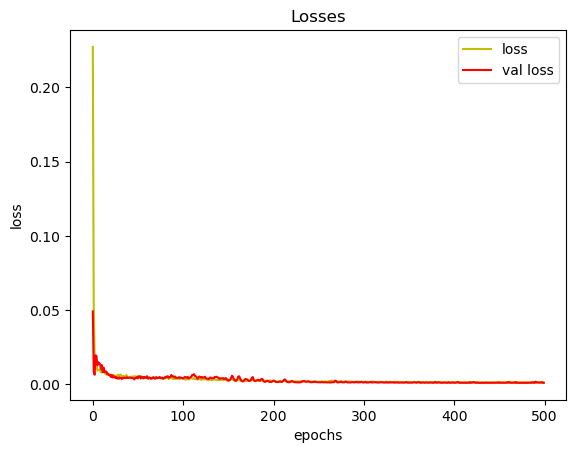

In [234]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [235]:
y_pred = model.predict(X_test)

5/5 [==============================] - 3s 17ms/step


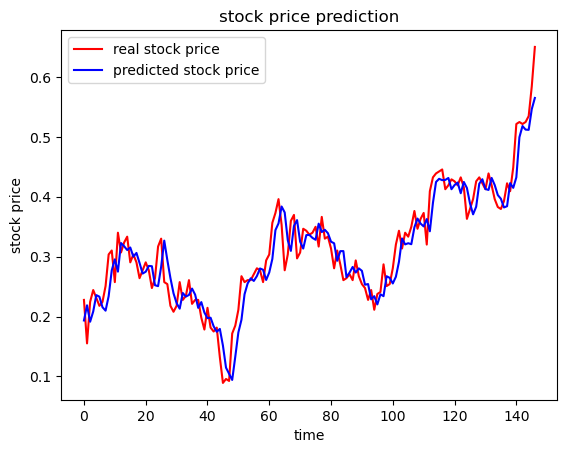

In [236]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()